# Development for code review: MMRDNS

## Notes
---
#### Aug 12th 2017
* Current issue: Amplitudes and phases of time domain waveforms are sligtly off (independently of spheroidal functions)
* Now the spheroidal harmonic function works as expected! :DDD
    * Errors (typically less than 1%) are now dominated by the fits used for the normalization constants.
* Bug found and fixed in spheroidal LAL function: ```a0``` and ```a1``` must be initiated as ```COMPLEX16``` but they were defined as ```double```.
* As a result of yesterday's discovery about the fit for QNM frequencies, I have implemented interpolation over QNM frequencies and separation constants by adding LALSimRingdownDATA.h to the workflow. The new related functions are ```XLALSimQNM_CW``` and ```XLALSimQNM_SC```.

#### Aug 11th 2017
* The discovery below was not enough. HOWEVER this did lead to another discovery --- THE FIT USED for the QNM frequencies and separation constants IS NOT ACCURATE ENOUGH to be used with the summation associated with spherodial harmonic calculation. 
* DISCOVERY: the convention used for the QNM frequencies in ```XLALcomplexOmega``` requires a conjugate in XLALcomplexOmega ```XLALSpinWeightedSpheroidalHarmonic```. Importantly, this is not the case for ```XLALseparationConstant```. This may fianlly fix ```XLALSpinWeightedSpheroidalHarmonic```.
* Adding check of normalization: fit in LAL vs direct numerical calculation in python
* Fixing the bug below helps, but now there are nans for low inclinaitons returned, and morphology of Slm are still a bit off for $(3,2,0)$.
* Bug found in the Spheroidal function:
``` C
// Incorrect
dY = pow(a2*(1.0+u),k);
```
Should be 
``` C
// Correct
dY = a2 * pow(1.0+u,k);
```
* There is definitely a noticeable error/bug in the LAL Spheroidal harmonic function: the amplitde and phase is off by ~10 percent for the q=1 test case
    * The LAL spheroidal harmonics are not properly normalized. 
    * In some cases (e.g. $(l,m)=(3,2)$) the morphology of the spheroidal harmonic function is incorrect AND not properly normalized
* Adding overall conjugation to output of Amplitude fit -- switching to correct phase convention
``` C
/*NOTE that the MATLAB code used to perform the fitting uses a different convention when handling the real and imaginary parts of psi4 than we will use here. The conjugation below makes the output of MMRDNS consistent with nrutils, which injects no manual minus signs when handling psi4, but enforces a phase convention: m>0 has frequencies >0 (non-precessing). NOTE that this may change in the future if significantly precessing systems are found to not sufficiently obey this property. See https://github.com/llondon6/nrutils_dev/blob/master/nrutils/core/nrsc.py#L1714-L1728 for more details.*/
ans = conj( ans );
```
* I've locally modified a line in the LAL Amplitude function
``` C
  /* If m<0, then take the conjugate */
  if ( input_m < 0 ) {
    /**/
    // OLD: ans = conj( ans );
    ans = pow(-1,l) * conj( ans );
  }
```

#### Aug 10th 2017
* Adding mode-by-mode comparisons and making separate section for full signal comparison
* I suspect an incorrect usage of the fninal mass fit: lalsim.E_rad_nonspinning_UIB2016(eta) --- the usage here turned out to be OK.

#### Aug 9th 2017
* (no longer of interest) The definition of time in the LAL version is correct but inconsistent with the model's construction. 
    * Tentatively changed in my version of the LAL Code by having T0=10M within the code. 
    * A better change may be to rescale the model itself with the LAL code.
* There is something incorrect about how the multipoles are being added together: when modes beyond the fundmental are added, a strange modulation is

## Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
#
# from os import system
# system('source ~/.virtual_enviroments/ringdownFD_nikhef/bin/activate')
from nrutils.core.basics import lalphenom
from kerr import rgb,gmvpfit,modelrd,anglep,qnmfit,leaver,ndflatten,sunwrap,alert,cyan,slm
from kerr.models import mmrdns as ns
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
import corner
#
from numpy import *
from numpy.linalg import pinv
#
from nrutils.core.units import *
#
from scipy.optimize import minimize
from os.path import expanduser
#
import lal
from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
import lalsimulation as lalsim
alert('The LASIMULATION version is located at: %s'%( bold(yellow(lalsim.__path__[0])) ))
#
import review_ringdownFD_nikhef as review

(<module>)>> The LASIMULATION version is located at: /Users/book/.virtual_enviroments/ringdownFD_nikhef/opt/lalsuite/lib/python2.7/site-packages/lalsimulation


## Select and Load NR Data

In [22]:
# Find simlations to load 
# A = scsearch(keyword='D11_q1.00_a0.0_m240',verbose=True)
A = scsearch(keyword='hrq',q=2,verbose=True)
# A = scsearch(keyword='D9_q1.2_a0.0_m160',verbose=True)
# A = scsearch(nonspinning=True,q=1.2,verbose=True,institute='gt',keyword='hrq')

(scsearch)>> Found keyword (='hrq') keyword.
(scsearch)>> Found q (=2) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q2.00	(D9_q2.0_a0.0_m160)



In [23]:
# Load simulation data
a = A[0]
# y = gwylm( a, lm=[(2,2)], verbose=True )
y = gwylm( a, lm=[(2,2),(3,3),(3,2),(4,4),(4,3),(5,5)], verbose=True )

(gwylm)>> Found dt (=0.15) keyword.
(gwylm)>> Found lm (=[(2, 2), (3, 3), (3, 2), (4, 4), (4, 3), (5, 5)]) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x10c26d3b0>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(validate!)>> Multiple catalog directories found. We will scan through the related list, and then store first the catalog_dir that the OS can find.
(validate!)>> Selecting "/Volumes/athena/bradwr/"
(gwylm)>> The (extraction_parameter,level) is (75.0,None), which differs from the config values of (75,0). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (3, 3), (3, 2), (4, 4), (4, 3), (5, 5)]
(load)>> Loading: mp_WeylScal4::Psi4i_l2_m2_r75.00.asc
(load)>> Imposing a default padding of 4 to the data.
(pad_wfarr)>> The shape was (7327, 3). Now the shape is (7331, 3).
(load)>> Loa

In [24]:
#
yrd = y.ringdown(T0=10,use_peak_strain=False,verbose=True)

(ringdown)>> Time will be listed relative to the peak of luminosity.


In [25]:
# Define physical parameters for LAL comparison
M_Sol = 50
Mf_Sol = 1.00002821*M_Sol * y.mf
D_Mpc = 150
inclination = 0
fmin = 20
phi_ref = 0
#
M = M_Sol*MSUN_SI
Mf = Mf_Sol*MSUN_SI
D = D_Mpc*1.0e6*PC_SI
#
t_code = yrd.lm[2,2]['strain'].t
deltaT = physt( diff(t_code)[0], M_Sol )
xf = y.xf
eta = y.eta

### Spot check final mass fit 

In [26]:
print '>> From LAL UIB Fit: Mf = ',1-lalsim.E_rad_nonspinning_UIB2016(eta)
print '>> From NR metadata: Mf = ',y.mf
print '>> Estimated initial mass: M_Sol = ', lalsim.Mf_to_M_nonspinning_UIB2016(eta, Mf_Sol)
print '>> Desired initial mass  : M_Sol = ', M_Sol

>> From LAL UIB Fit: Mf =  0.961212591868
>> From NR metadata: Mf =  0.961196467981
>> Estimated initial mass: M_Sol =  50.00057175
>> Desired initial mass  : M_Sol =  50


### Directly compare amplitude functions

In [27]:
from kerr.formula.mmrdns_amplitudes import A_strain as Afitraw
for l,m,n in ns.lmn:
    Alal = lalsim.MMRDNSAmplitudeOverOmegaSquared(eta, l, m, n)
    Apy  = ns.Afit(l, m, n, eta)
    print '>> From LAL MMRDNS Fit: A%i%i%i = '%(l,m,n),Alal
    print '>> From PY  MMRDNS Fit: A%i%i%i = '%(l,m,n),Apy
    print '>> From RAWPY      Fit: A%i%i%i = '%(l,m,n), Afitraw[l,m,n](eta).conj()
    print '## Error (%) = ',100*abs((Alal-Apy)/abs(Apy))
    print '---'

>> From LAL MMRDNS Fit: A220 =  (-0.203841104762-0.05886848463j)
>> From PY  MMRDNS Fit: A220 =  (-0.203841104762-0.05886848463j)
>> From RAWPY      Fit: A220 =  (-0.203841104762-0.05886848463j)
## Error (%) =  0.0
---
>> From LAL MMRDNS Fit: A221 =  (0.0303219912567-0.0321751333749j)
>> From PY  MMRDNS Fit: A221 =  (0.0303219912567-0.0321751333749j)
>> From RAWPY      Fit: A221 =  (0.0303219912567-0.0321751333749j)
## Error (%) =  0.0
---
>> From LAL MMRDNS Fit: A210 =  (0.0182007119949+0.0216813061027j)
>> From PY  MMRDNS Fit: A210 =  (0.0182007119949+0.0216813061027j)
>> From RAWPY      Fit: A210 =  (0.0182007119949+0.0216813061027j)
## Error (%) =  0.0
---
>> From LAL MMRDNS Fit: A330 =  (-0.0288318057181+0.0252304620238j)
>> From PY  MMRDNS Fit: A330 =  (-0.0288318057181+0.0252304620238j)
>> From RAWPY      Fit: A330 =  (-0.0288318057181+0.0252304620238j)
## Error (%) =  0.0
---
>> From LAL MMRDNS Fit: A331 =  (-0.00257931054392-0.0126258545335j)
>> From PY  MMRDNS Fit: A331 =  (-

## Compare methods for Ringdown Frequencies and Separation Constants

In [28]:
lalsim.QNM_CW(0,2,2,0)
# plot( lalsim.JF_DATA, lalsim.SC220REAL_DATA )

(0.37367168446509785-0.088962315683355j)

In [29]:
#
for l,m,n in ns.lmn:

    #
    # kappa = lalsim.KAPPA(xf,l,m)
    # cwlal = array([lalsim.complexOmega(kappa,l,m,n)]).conj()[0]
    # sclal = lalsim.separationConstant( kappa, l, m, n )
    cwlal = lalsim.QNM_CW(xf,l,m,n)
    sclal = lalsim.QNM_SC(xf,l,m,n)
    
    

    #
    z = (l,m,n)
    cwpy,scpy = leaver(xf,l,m,n)

    #
    print '---'
    print '>> From LAL: cw%i%i%i = %s\t(Polynomial Fit -- Conjugate)'%(l,m,n,cwlal)
    print '>> From  PY: cw%i%i%i = %s\t(Leaver\'s Method)'%(l,m,n,cwpy)
    print '## Error (%) = ',100*abs((cwlal-cwpy)/abs(cwpy))
    print '\\\\ From LAL: sc%i%i%i = %s\t(Polynomial Fit)'%(l,m,n,sclal)
    print '\\\\ From  PY: sc%i%i%i = %s\t(Leaver\'s Method)'%(l,m,n,scpy)
    print '## Error (%) = ',100*abs((sclal-scpy)/abs(scpy))

---
>> From LAL: cw220 = (0.502108717456-0.0831956587184j)	(Polynomial Fit -- Conjugate)
>> From  PY: cw220 = (0.502108717464-0.0831956587169j)	(Leaver's Method)
## Error (%) =  1.72409441909e-09
\\ From LAL: sc220 = (3.09372332047+0.163022234708j)	(Polynomial Fit)
\\ From  PY: sc220 = (3.09372332043+0.163022234703j)	(Leaver's Method)
## Error (%) =  1.29669413828e-09
---
>> From LAL: cw221 = (0.488488079331-0.251969486286j)	(Polynomial Fit -- Conjugate)
>> From  PY: cw221 = (0.488488079339-0.251969486282j)	(Leaver's Method)
## Error (%) =  1.76089134394e-09
\\ From LAL: sc221 = (3.13765202788+0.491450024257j)	(Polynomial Fit)
\\ From  PY: sc221 = (3.13765202783+0.491450024241j)	(Leaver's Method)
## Error (%) =  1.4463041727e-09
---
>> From LAL: cw210 = (0.440036730955-0.0840823603917j)	(Polynomial Fit -- Conjugate)
>> From  PY: cw210 = (0.440036730958-0.0840823603904j)	(Leaver's Method)
## Error (%) =  6.84156813613e-10
\\ From LAL: sc210 = (3.59159084258+0.0870409534668j)	(Polynomial

## Compare ALPHA, BETA & GAMMA functions for Spheroidal Harmonic calculation

In [30]:
#
l,m,n, = 4,4,0

u = array( [cos(0)] )

#
kappa = lalsim.KAPPA(xf,l,m)
cw = lalsim.QNM_CW(xf,l,m,n) # array([lalsim.complexOmega(kappa,l,m,n)]).conj()[0]
Alm = lalsim.QNM_SC(xf,l,m,n) # lalsim.separationConstant( kappa, l, m, n )
    
#
# cw,Alm = leaver(xf,l,m,n)
aw = cw*xf

s = -2

a0 = 1.0 
a1 = -lalsim.BETA_RD(m,s,0,aw,Alm)/lalsim.ALPHA_RD(m,s,0)

# the sum part
done = False
Y = a0*ones(u.shape,dtype=complex256)
Y = Y + a1*(1.0+u)
k = 1
kmax = 2e3
err,yy = [],[]
et2=1e-8
max_a = max(abs(array([a0,a1])))
while not done:
    k += 1
    j = k-1
    a2 = -1.0*( lalsim.BETA_RD(m,s,j,aw,Alm)*a1 + lalsim.GAMMA_RD(m,s,j,aw)*a0 ) / lalsim.ALPHA_RD(m,s,j)
    dY = a2*(1.0+u)**k
    Y += dY
    xx = max(abs( dY ))
    print j, a2

    done = (k>=l) and ( (xx<et2 and k>30) or k>kmax )
    done = done or xx<et2
    a0 = a1
    a1 = a2

# raise

1 (0.107501381291-0.0181904803102j)
2 (-0.0205326975429+0.00525801375502j)
3 (0.00321907954383-0.00111488150316j)
4 (-0.000432436054747+0.000190957535319j)
5 (5.10648526894e-05-2.77663143578e-05j)
6 (-5.39040454888e-06+3.5318555586e-06j)
7 (5.14622220311e-07-4.00944338012e-07j)
8 (-4.48069229947e-08+4.1207056373e-08j)
9 (3.578972632e-09-3.87549418298e-09j)
10 (-2.63288110554e-10+3.36343044452e-10j)
11 (1.7873190625e-11-2.71177359346e-11j)
12 (-1.11996093245e-12+2.04226188159e-12j)
13 (6.42920270621e-14-1.44370620008e-13j)


#### ALPHA

In [31]:
#
p = 2
s = -2

#
for l,m,n in ns.lmn:
    
    #
    cw = lalsim.QNM_CW(xf,l,m,n) 
    Alm = lalsim.QNM_SC(xf,l,m,n) 
    aw = cw*xf

    #
    alal = lalsim.ALPHA_RD(m,s,p)

    #
    z = (l,m,n)
    k1 = 0.5*abs(m-s)
    k2 = 0.5*abs(m+s)
    apy = -2.0*(p+1.0)*(p+2.0*k1+1.0)

    #
    print '---'
    print '>> From LAL: alpha%i%i%i = '%(l,m,n),alal
    print '>> From  PY: alpha%i%i%i = '%(l,m,n),apy
    print '## Error (%) = ',100*abs((alal-apy)/abs(apy))

---
>> From LAL: alpha220 =  (-42+0j)
>> From  PY: alpha220 =  -42.0
## Error (%) =  0.0
---
>> From LAL: alpha221 =  (-42+0j)
>> From  PY: alpha221 =  -42.0
## Error (%) =  0.0
---
>> From LAL: alpha210 =  (-36+0j)
>> From  PY: alpha210 =  -36.0
## Error (%) =  0.0
---
>> From LAL: alpha330 =  (-48+0j)
>> From  PY: alpha330 =  -48.0
## Error (%) =  0.0
---
>> From LAL: alpha331 =  (-48+0j)
>> From  PY: alpha331 =  -48.0
## Error (%) =  0.0
---
>> From LAL: alpha320 =  (-42+0j)
>> From  PY: alpha320 =  -42.0
## Error (%) =  0.0
---
>> From LAL: alpha440 =  (-54+0j)
>> From  PY: alpha440 =  -54.0
## Error (%) =  0.0
---
>> From LAL: alpha430 =  (-48+0j)
>> From  PY: alpha430 =  -48.0
## Error (%) =  0.0
---
>> From LAL: alpha550 =  (-60+0j)
>> From  PY: alpha550 =  -60.0
## Error (%) =  0.0


#### BETA

In [32]:
#
p = 4
s = -2

#
for l,m,n in ns.lmn:
    
    #
    cw = lalsim.QNM_CW(xf,l,m,n) 
    Alm = lalsim.QNM_SC(xf,l,m,n) 
    aw = cw*xf

    #
    blal = lalsim.BETA_RD(m,s,p,aw,Alm)

    #
    z = (l,m,n)
    k1 = 0.5*abs(m-s)
    k2 = 0.5*abs(m+s)
    bpy = p*(p-1.0)+2.0*p*(k1+k2+1.0-2.0*aw) -( 2.0*aw*(2.0*k1+s+1.0)-(k1+k2)*(k1+k2+1.0) ) - ( aw*aw + s*(s+1.0) + Alm)

    #
    print '---'
    print '>> From LAL: beta%i%i%i = '%(l,m,n),blal
    print '>> From  PY: beta%i%i%i = '%(l,m,n),bpy
    print '## Error (%) = ',100*abs((blal-bpy)/abs(bpy))

---
>> From LAL: beta220 =  (29.9256365999+1.01029298224j)
>> From  PY: beta220 =  (29.9256365999+1.01029298224j)
## Error (%) =  0.0
---
>> From LAL: beta221 =  (30.0957063103+3.05942956515j)
>> From  PY: beta221 =  (30.0957063103+3.05942956515j)
## Error (%) =  0.0
---
>> From LAL: beta210 =  (30.8502987809+0.989904446825j)
>> From  PY: beta210 =  (30.8502987809+0.989904446825j)
## Error (%) =  0.0
---
>> From LAL: beta330 =  (32.9364160424+1.19970560443j)
>> From  PY: beta330 =  (32.9364160424+1.19970560443j)
## Error (%) =  0.0
---
>> From LAL: beta331 =  (33.0523248573+3.61482135353j)
>> From  PY: beta331 =  (33.0523248573+3.61482135353j)
## Error (%) =  0.0
---
>> From LAL: beta320 =  (20.4682810594+1.14561726957j)
>> From  PY: beta320 =  (20.4682810594+1.14561726957j)
## Error (%) =  0.0
---
>> From LAL: beta440 =  (35.274876059+1.37043336829j)
>> From  PY: beta440 =  (35.274876059+1.37043336829j)
## Error (%) =  0.0
---
>> From LAL: beta430 =  (21.4003960146+1.29325986113j)
>> 

#### GAMMA

In [33]:
#
p = 4
s = -2

#
for l,m,n in ns.lmn:
    
    #
    cw = lalsim.QNM_CW(xf,l,m,n) 
    Alm = lalsim.QNM_SC(xf,l,m,n) 
    aw = cw*xf

    #
    glal = lalsim.GAMMA_RD(m,s,p,aw)

    #
    z = (l,m,n)
    k1 = 0.5*abs(m-s)
    k2 = 0.5*abs(m+s)
    gpy = 2.0*aw*(p+k1+k2+s)

    #
    print '---'
    print '>> From LAL: gamma%i%i%i = '%(l,m,n),glal
    print '>> From  PY: gamma%i%i%i = '%(l,m,n),gpy
    print '## Error (%) = ',100*abs((glal-gpy)/abs(gpy))

---
>> From LAL: gamma220 =  (2.50377379471-0.414856589601j)
>> From  PY: gamma220 =  (2.50377379471-0.414856589601j)
## Error (%) =  0.0
---
>> From LAL: gamma221 =  (2.43585424737-1.25645019673j)
>> From  PY: gamma221 =  (2.43585424737-1.25645019673j)
## Error (%) =  0.0
---
>> From LAL: gamma210 =  (2.19425076158-0.419278142815j)
>> From  PY: gamma210 =  (2.19425076158-0.419278142815j)
## Error (%) =  0.0
---
>> From LAL: gamma330 =  (4.97605618087-0.534171052867j)
>> From  PY: gamma330 =  (4.97605618087-0.534171052867j)
## Error (%) =  0.0
---
>> From LAL: gamma331 =  (4.92877811633-1.60970108212j)
>> From  PY: gamma331 =  (4.92877811633-1.60970108212j)
## Error (%) =  0.0
---
>> From LAL: gamma320 =  (3.64288558983-0.432229314937j)
>> From  PY: gamma320 =  (3.64288558983-0.432229314937j)
## Error (%) =  0.0
---
>> From LAL: gamma440 =  (8.08845798301-0.652222064254j)
>> From  PY: gamma440 =  (8.08845798301-0.652222064254j)
## Error (%) =  0.0
---
>> From LAL: gamma430 =  (6.292618

## Compare Spheroidal Harmonic Normalization

In [34]:
#
from kerr import ssprod
#
for l,m,n in ns.lmn:

    #
    kappa = lalsim.KAPPA(xf,l,m)
    Nlal = lalsim.spheroidalHarmonicNormalization(kappa,l,m,n)

    #
    z = (l,m,n)
    Npy = sqrt( ssprod(xf,z,z) )

    #
    print '---'
    print '>> From LAL: N%i%i%i = '%(l,m,n),Nlal
    print '>> From  PY: N%i%i%i = '%(l,m,n),Npy
    print '## Error (%) = ',100*abs((Nlal-Npy)/abs(Npy))

---
>> From LAL: N220 =  6.63245304896
>> From  PY: N220 =  (6.63276432887+0j)
## Error (%) =  0.00469306453256
---
>> From LAL: N221 =  6.61176625895
>> From  PY: N221 =  (6.61248563173+0j)
## Error (%) =  0.0108790070992
---
>> From LAL: N210 =  3.09113174966
>> From  PY: N210 =  (3.09059758042+0j)
## Error (%) =  0.0172836879562
---
>> From LAL: N330 =  3.92212614672
>> From  PY: N330 =  (3.9219911798+0j)
## Error (%) =  0.00344128581757
---
>> From LAL: N331 =  3.92134759342
>> From  PY: N331 =  (3.92137230404+0j)
## Error (%) =  0.000630152534194
---
>> From LAL: N320 =  0.904845861609
>> From  PY: N320 =  (0.904361025994+0j)
## Error (%) =  0.0536108479992
---
>> From LAL: N440 =  2.69375282164
>> From  PY: N440 =  (2.69340143041+0j)
## Error (%) =  0.0130463742009
---
>> From LAL: N430 =  0.607198742661
>> From  PY: N430 =  (0.606614065145+0j)
## Error (%) =  0.0963837717574
---
>> From LAL: N550 =  1.97144927458
>> From  PY: N550 =  (1.97081389491+0j)
## Error (%) =  0.03223945

## Compare Spheroidal Harmonic Functions

In [35]:

#
for l,m,n in ns.lmn:

    #
    slal = lalsim.SpinWeightedSpheroidalHarmonic( xf, l, m, n, inclination, phi_ref )

    #
    spy = slm( xf,l,m,n,inclination,phi_ref,norm=True )

    #
    print '---'
    print '>> From LAL: S%i%i%i(theta,phi) = '%(l,m,n),slal
    print '>> From  PY: S%i%i%i(theta,phi) = '%(l,m,n),spy
    print '## Error (%) = ',100*abs((slal-spy)/abs(spy))


---
>> From LAL: S220(theta,phi) =  (0.675927122242-0.0139392653913j)
>> From  PY: S220(theta,phi) =  (0.675895400556-0.0139386112115j)
## Error (%) =  0.00469328335023
---
>> From LAL: S221(theta,phi) =  (0.673125291081-0.0419308521285j)
>> From  PY: S221(theta,phi) =  (0.673052061743-0.0419262904647j)
## Error (%) =  0.0108801891683
---
>> From LAL: S210(theta,phi) =  0j
>> From  PY: S210(theta,phi) =  0j
## Error (%) =  nan
---
>> From LAL: S330(theta,phi) =  (-0-0j)
>> From  PY: S330(theta,phi) =  (-0+0j)
## Error (%) =  nan
---
>> From LAL: S331(theta,phi) =  (-0-0j)
>> From  PY: S331(theta,phi) =  (-0+0j)
## Error (%) =  nan
---
>> From LAL: S320(theta,phi) =  (0.765967157605+0.0121456300953j)
>> From  PY: S320(theta,phi) =  (0.766377799093+0.0121521414706j)
## Error (%) =  0.0535821221614
---
>> From LAL: S440(theta,phi) =  0j
>> From  PY: S440(theta,phi) =  0j
## Error (%) =  nan
---
>> From LAL: S430(theta,phi) =  (-0+0j)
>> From  PY: S430(theta,phi) =  0j
## Error (%) =  nan


/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in clongdouble_scalars


---
>> From LAL: S550(theta,phi) =  (-0-0j)
>> From  PY: S550(theta,phi) =  (-0+0j)
## Error (%) =  nan


>> Checking Normalization
Python:  (1+0j)
LAL:     (0.999739123546+0j)


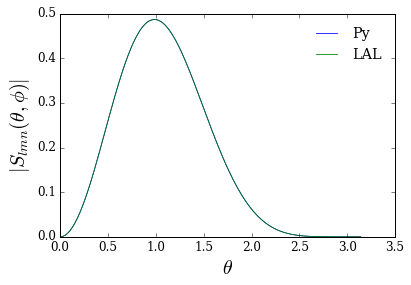

In [36]:

#
l,m,n = 4,4,0
jf = xf

#
theta = linspace(0,pi,5e2)
phi = 0

#
Spy = slm( jf,l,m,n,theta,phi )
Slal = array( [ lalsim.SpinWeightedSpheroidalHarmonic( jf, l, m, n, th, phi ) for th in theta ] )

#
plot( theta, abs(Spy), label = 'Py' )
plot( theta, abs(Slal), label = 'LAL' )

#
legend( frameon=False )
xlabel(r'$\theta$')
ylabel(r'$|S_{lmn}(\theta,\phi)|$')

#
print '>> Checking Normalization'
print 'Python: ', 2*pi*trapz(Spy*Spy.conj()*sin(theta),theta )
print 'LAL:    ', 2*pi*trapz(Slal*Slal.conj()*sin(theta),theta )

## Compare LAL and Python Models

0.0 3.70794823605e-05 9.55719114837e+31 0.62331465967 0.222222111111 0 0 2 2 0 4.62851637224e+24 0 0 406 0.0
(-2.2107934089e-21-5.89366148468e-22j)
(-2.21092435915e-21-5.8940105794e-22j)
Error (%) = 0.005923
0.99994077127


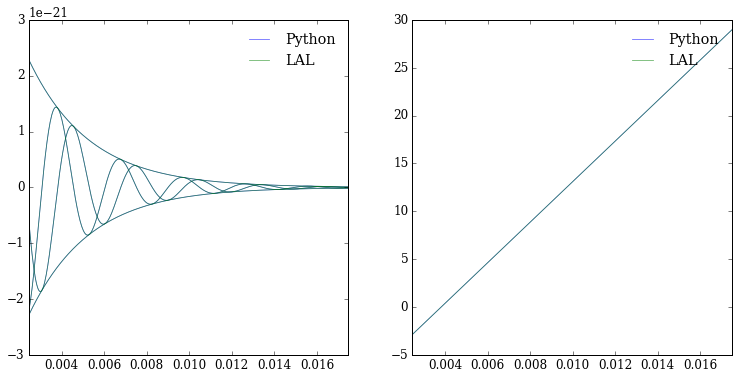

In [37]:

#
l,m,n = 2,2,0

#
# pyh = ns.meval_mode(l,m,n,eta)(t_code)
pyh = physh( ns.meval_mode(l,m,n,eta)(t_code), M_Sol, D_Mpc ) * slm(xf,l,m,n,inclination,phi_ref)
# pyh = physh( ns.meval_mode(l,m,n,eta)(t_code), M_Sol, D_Mpc )

# No spheroidal harmonic scaling used here
lah_raw = lalsim.SimRingdownGenerateSingleModeMMRDNS_time( 0.0, deltaT,Mf,xf,eta,inclination,phi_ref,l,m,n,D,0,0,len(t_code), physt(0,M_Sol) )
print 0.0, deltaT,Mf,xf,eta,inclination,phi_ref,l,m,n,D,0,0,len(t_code), physt(0,M_Sol)
# lah_raw = lalsim.SimRingdownGenerateSingleBareModeMMRDNS_time( 0.0, deltaT,Mf,xf,eta,l,m,n,D,0,0,len(t_code), physt(0,M_Sol) )
lah = lah_raw.data.data

#
t = physt(t_code,M_Sol)

#
fig = figure( figsize = 6*array([2.1,1]) )

#
def plotc(t, c,color='k',alpha=1,label=None,linestyle='-'):
    #
    subplot(1,2,1)
    alpha = 0.6
    plot( t, c.real, color = color, alpha=alpha, label=label,linestyle=linestyle )
    plot( t, c.imag, color = color, alpha=alpha,linestyle=linestyle )
    plot( t, abs(c), color = color, alpha=alpha,linestyle=linestyle )
    plot( t,-abs(c), color = color, alpha=alpha,linestyle=linestyle )
    xlim( lim(t) )
    legend( frameon=False )
    #
    subplot(1,2,2)
    alpha = 0.6
    plot( t, unwrap(angle(c)), color = color, alpha=alpha, label=label,linestyle=linestyle )
    xlim( lim(t) )
    legend( frameon=False )

    
plotc( t, pyh, color='b', label = 'Python',linestyle='-' )
plotc( t, lah, color='g', label = 'LAL',linestyle='-' )


# print abs(pyh[0])/abs(lah[0])
# from nrutils.core.units import __physical_constants__
# print __physical_constants__['mass_sun_secs']
# print lal.MTSUN_SI/lal.MSUN_SI

print pyh[0]
print lah[0]
print 'Error (%%) = %f' % ( 100*average( abs(pyh-lah)[0]/abs(lah)[0] ) )
print abs(pyh[0]/lah[0])

## Compare Recomposed Waveforms

In [38]:

#
yrd.align( ns.meval() ,verbose=True,plot=True)

# Format NR Waveform 
hnr = physh( yrd.recompose(inclination,phi_ref,kind='strain',domain='time').wfarr, M_Sol, D_Mpc )

# Eval python model 
hpy = physh( ns.meval( inclination, phi_ref, eta, kind='strain' )(t_code), M_Sol, D_Mpc )

# Evaluate LAL model
hlal_raw = lalsim.SimRingdownMMRDNS_time(0.0,deltaT,Mf,xf,eta,inclination,phi_ref,D,nonGRparams=None)
chlal = hlal_raw[0].data.data - 1j*hlal_raw[1].data.data

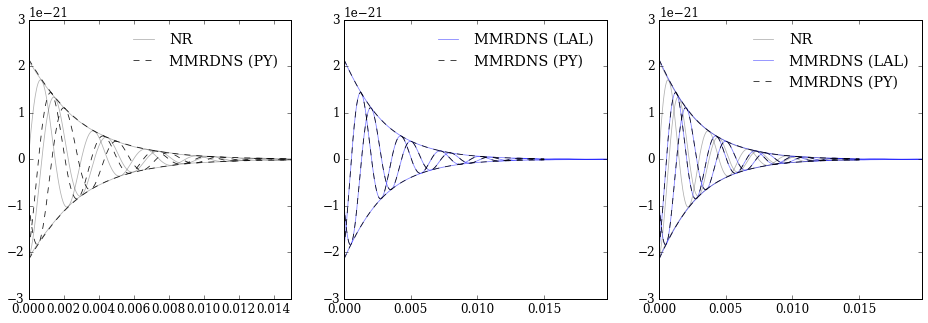

In [39]:
#
fig = figure( figsize=5*array([3.2,1]) )

#
def plotnr():
    t = hnr[:,0]
    # Plot NR Waveform
    nr_alpha = 0.3
    # Shift time to align with LAL verision
    plot( t-t[0], hnr[:,1], 'k', alpha=nr_alpha )
    plot( t-t[0], hnr[:,2], 'k', alpha=nr_alpha )
    chnr = hnr[:,1]+1j*hnr[:,2]
    plot( t-t[0], abs(chnr), 'k', alpha=nr_alpha, label='NR' )
    plot( t-t[0],-abs(chnr), 'k', alpha=nr_alpha )
    if False:
        ll,mm = 2,2
        hlallmraw = lalsim.SimRingdownGenerateSingleBareModeMMRDNS_time( 0.0, deltaT,M,xf,eta,ll,mm,0,D,0,0,len(t),0.0 )
        hlal22 = sYlm(-2,ll,mm,inclination,phi_ref)*hlallmraw.data.data
        plot( t-t[0],abs(hlal22),'--r',label='LAL (2,2,0) ONLY')
        plot( t-t[0],-abs(hlal22),'--r' )
    xlim( lim(t-t[0]) )
    #
    legend( frameon=False )

#
def plotlal():
    alpha = 0.5
    t = deltaT * arange( len(chlal) )
    # Plot LAL Waveform
    plot( t, chlal.real, 'b', alpha=alpha )
    plot( t, chlal.imag, 'b', alpha=alpha )
    plot( t, abs(chlal), 'b', label='MMRDNS (LAL)',alpha=alpha )
    plot( t,-abs(chlal), 'b',alpha=alpha )
    xlim( lim(t) )
    #
    legend( frameon=False )
    
#
def plotpy():
    alpha=0.90
    color = 'k'
    t = physt(t_code-t_code[0],M_Sol)
    plot( t, hpy.real, '--',alpha=alpha, color=color, label='MMRDNS (PY)'  )
    plot( t, hpy.imag, '--',alpha=alpha, color=color  )
    plot( t, abs(hpy), '--',alpha=alpha, color=color  )
    plot( t,-abs(hpy), '--',alpha=alpha, color=color  )
    #
    legend( frameon=False )

#
subplot(1,3,1)
plotnr()
plotpy()
#
subplot(1,3,2)
plotlal()
plotpy()
#
subplot(1,3,3)
plotnr()
plotlal()
plotpy()


## Compute Faithfulness 